# NLP - Amazon Reviews Automotive

## Tabla de Contenidos
1. [1. Descarga y exploración del corpus](#1.-Descarga-y-exploración-del-corpus)
   - [1.1 Carga del dataset](#1.1-Carga-del-dataset)
   - [1.2 Cardinalidad del vocabulario](#1.2-Cardinalidad-del-vocabulario)
   - [1.3 Distribución de reviews por número de estrellas](#1.3-Distribución-de-reviews-por-número-de-estrellas)
   - [1.4 Número de reviews positivas y negativas](#1.4-Número-de-reviews-positivas-y-negativas)
   - [1.5 N-gramas más frecuentes](#1.5-N-gramas-más-frecuentes)
   - [1.6 Nubes de palabras](#1.6-Nubes-de-palabras)
   - [1.7 Visualización de word embeddings (Word2Vec)](#1.7-Visualización-de-word-embeddings-(Word2Vec))
   - [1.8 Conclusiones de la exploración](#1.8-Conclusiones-de-la-exploración)
         

2. [2. Preprocesado de texto](#2.-Preprocesado-de-texto)
   - [2.1 Función principal de preprocesado](#2.1-Función-principal-de-preprocesado)
   - [2.2 Subfunciones de limpieza](#2.2-Subfunciones-de-limpieza)

          
3. [3. Entrenamiento y testeo](#3.-Entrenamiento-y-testeo)
   - [3.1 Preparación de datos](#3.1-Preparación-de-datos)
   - [3.2 Modelo 1](#3.2-Modelo-1)
   - [3.3 Modelo 2](#3.3-Modelo-2)

         
4. [4. Métricas y conclusiones](#4.-Métricas-y-conclusiones)
   - [4.1 Métricas del modelo seleccionado](#4.1-Métricas-del-modelo-seleccionado)
   - [4.2 Conclusiones finales](#4.2-Conclusiones-finales)

## 1. Descarga y exploración del corpus

In [1]:
# Instalar dependencias
#!pip install -r ../requirements.txt
# !python -m spacy download en_core_web_sm
# !python -m spacy download es_core_news_sm1.1
#!pip install rarfile

In [2]:
# Configuración
import sys
sys.path.append('../')
from utils import *

Semilla establecida: 42


In [3]:
# Cargar dataset
zip_path = '../Data/reviews_Automotive_5.json.zip'  
filename_inside_zip = 'reviews_Automotive_5.json.gz'  

# Cargar dataset 
df = load_amazon_reviews_from_zip(zip_path, filename_inside_zip, sample_size=10000)

Dataset cargado exitosamente: 10000 reviews


### 1.2 Exploración inicial del dataset

In [4]:
# Mostrar información básica
print(f"Shape: {df.shape}")
print(f"Columnas: {list(df.columns)}")
df.head(3)

Shape: (10000, 9)
Columnas: ['reviewerID', 'asin', 'reviewerName', 'helpful', 'reviewText', 'overall', 'summary', 'unixReviewTime', 'reviewTime']


,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A3F73SC1LY51OO,B00002243X,Alan Montgomery,"[4, 4]",I needed a set of jumper cables for my new car...,5.0,Work Well - Should Have Bought Longer Ones,1313539200,"08 17, 2011"
1,A20S66SKYXULG2,B00002243X,alphonse,"[1, 1]","These long cables work fine for my truck, but ...",4.0,Okay long cables,1315094400,"09 4, 2011"
2,A2I8LFSN2IS5EO,B00002243X,Chris,"[0, 0]",Can't comment much on these since they have no...,5.0,Looks and feels heavy Duty,1374710400,"07 25, 2013"


In [5]:
# Información detallada del dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   reviewerID      10000 non-null  object 
 1   asin            10000 non-null  object 
 2   reviewerName    9836 non-null   object 
 3   helpful         10000 non-null  object 
 4   reviewText      10000 non-null  object 
 5   overall         10000 non-null  float64
 6   summary         10000 non-null  object 
 7   unixReviewTime  10000 non-null  int64  
 8   reviewTime      10000 non-null  object 
dtypes: float64(1), int64(1), object(7)
memory usage: 703.2+ KB


In [6]:
# Verificar valores nulos
print(df.isnull().sum())

reviewerID          0
asin                0
reviewerName      164
helpful             0
reviewText          0
overall             0
summary             0
unixReviewTime      0
reviewTime          0
dtype: int64


In [7]:
# Estadísticas descriptivas de columnas numéricas
df.describe()

,overall,unixReviewTime
count,10000.000000,1.000000e+04
mean,4.523500,1.359678e+09
std,0.919311,4.173744e+07
min,1.000000,1.121386e+09
25%,4.000000,1.347300e+09
50%,5.000000,1.370909e+09
75%,5.000000,1.388707e+09
max,5.000000,1.405382e+09


### 1.3 Cardinalidad del vocabulario

- Limpieza de los textos: eliminación nulos, conversión todos los valores a string, conversión a minúsculas.
- Separación de todas las palabras usando `.str.split()` y aplanación con `.explode()`.
- Se muestra el total de palabras, el número de palabras únicas, y las 10 más frecuentes en el corpus.

In [8]:
# Obtener textos limpios
texts = df['reviewText'].dropna().astype(str).str.lower()
tokens = texts.str.split().explode()
vocabulary_counter = Counter(tokens)

print(f"Total de palabras: {len(tokens):,}")
print(f"Palabras únicas (Counter): {len(vocabulary_counter):,}")

print("\nTop 10 palabras más frecuentes:")
for token, freq in vocabulary_counter.most_common(10):
    print(f"  {token}: {freq:,}")

Total de palabras: 781,502
Palabras únicas (Counter): 45,419

Top 10 palabras más frecuentes:
  the: 40,027
  and: 22,282
  to: 21,765
  i: 20,537
  a: 20,499
  it: 16,744
  is: 10,860
  of: 10,793
  this: 10,773
  for: 9,455


### 1.4 Distribución de reviews por número de estrellas

Se analiza la variable `overall`, que representa la puntuación otorgada por los usuarios en formato de estrellas (de 1 a 5).

- Cálculo del número total de reviews por cada nivel de estrella utilizando `.value_counts()` ordenado por índice.
- Se muestra la cantidad absoluta y el porcentaje que representa cada puntuación respecto al total del dataset.
- Se visualiza la distribución mediante un gráfico de barras para facilitar la interpretación del equilibrio entre puntuaciones.

In [9]:
# Distribución de ratings por estrellas
rating_counts = df['overall'].value_counts().sort_index()
print("Distribución de reviews por estrellas:")
for stars, count in rating_counts.items():
    percentage = (count / len(df)) * 100
    print(f"  {stars} estrella(s): {count:,} reviews ({percentage:.1f}%)")

Distribución de reviews por estrellas:
  1.0 estrella(s): 265 reviews (2.6%)
  2.0 estrella(s): 262 reviews (2.6%)
  3.0 estrella(s): 602 reviews (6.0%)
  4.0 estrella(s): 1,715 reviews (17.2%)
  5.0 estrella(s): 7,156 reviews (71.6%)


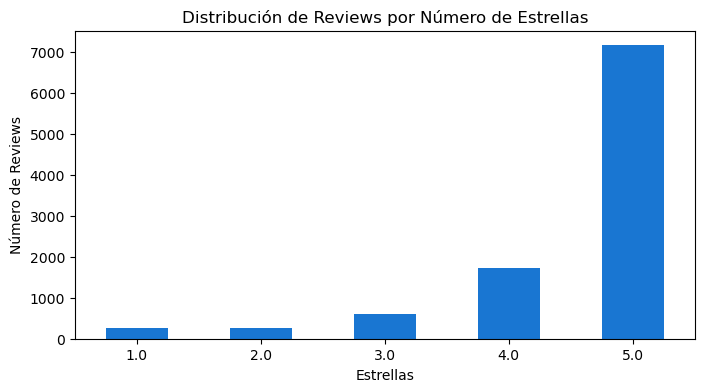

In [10]:
# Visualización
rating_counts.plot(kind='bar', figsize=(8, 4), color='#1976D2')

plt.title('Distribución de Reviews por Número de Estrellas')
plt.xlabel('Estrellas') 
plt.ylabel('Número de Reviews')

plt.xticks(rotation=0)
plt.show()

### 1.5 Número de reviews positivas y negativas

Clasificación de las reviews como positivas o negativas a partir de su puntuación (`overall`).

- Se aplica un umbral configurable (`threshold=3`) para diferenciar entre sentimientos negativos (≤3) y positivos (>3). El rating 3 se descarta porque se considera neutral.
- Se generan dos nuevas columnas: `sentiment` (binaria) y `sentiment_label` (texto).
- Se muestra la distribución resultante de cada clase y se representa gráficamente.


Distribución de sentimientos:
  positive: 8,871 reviews (88.7%)
  negative: 1,129 reviews (11.3%)


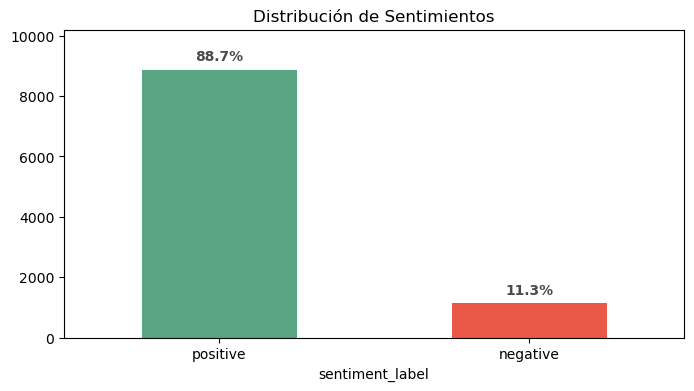

{'positive': {'count': 8871, 'percentage': 88.71},
 'negative': {'count': 1129, 'percentage': 11.29}}

In [11]:
# Crear sentimientos binarios usando función de utils
df = binary_sentiment(df, rating_col='overall', threshold=3)
analyze_sentiment_distribution(df)

### 1.6 N-gramas más frecuentes

Extracción de los n-gramas más frecuentes del corpus de texto para identificar patrones de lenguaje frecuentes que pueden ser útiles para tareas de modelado o visualización.

Se utilizan dos enfoques diferentes para extraer y analizar n-gramas, con el objetivo de validar los resultados:

- **NLTK**: Utiliza los tokens previamente procesados manualmente (limpieza consistente con análisis anterior)
- **CountVectorizer**: Aplica su propia tokenización y limpieza automática

**Observaciones:**
- Los **bigramas** muestran resultados consistentes entre ambos métodos (diferencias <2%)
- Los **trigramas** presentan mayor variabilidad, posiblemente debido a diferencias en el manejo de contracciones y signos de puntuación

In [12]:
# NLTK
tokens_list = tokens.tolist() 
bigrams = list(ngrams(tokens_list, 2))
trigrams = list(ngrams(tokens_list, 3))

# Calcular frecuencias
bigrams_freq = FreqDist(bigrams)
trigrams_freq = FreqDist(trigrams)

# Mostrar top 10
print("Top 10 más frecuentes - NLTK:")
print("Bigramas:")
for bigram, freq in bigrams_freq.most_common(10):
    print(f"  {' '.join(bigram)}: {freq:,}")

print("\nTrigramas:")
for trigram, freq in trigrams_freq.most_common(10):
    print(f"  {' '.join(trigram)}: {freq:,}")

Top 10 más frecuentes - NLTK:
Bigramas:
  of the: 2,738
  on the: 2,421
  in the: 2,253
  i have: 2,017
  it is: 1,665
  to the: 1,563
  is a: 1,472
  this is: 1,439
  if you: 1,365
  and the: 1,344

Trigramas:
  this is a: 486
  a lot of: 308
  i bought this: 282
  out of the: 251
  if you have: 243
  i have a: 239
  i have used: 225
  this is the: 218
  one of the: 217
  it is a: 203


In [13]:
# CountVectorizer
# Bigrams
vectorizer_bi = CountVectorizer(ngram_range=(2, 2))
X_bi = vectorizer_bi.fit_transform(texts)
bigrams = vectorizer_bi.get_feature_names_out()
bigram_counts = X_bi.sum(axis=0).A1
top_bigrams = sorted(zip(bigrams, bigram_counts), key=lambda x: x[1], reverse=True)

# Trigrams
vectorizer_tri = CountVectorizer(ngram_range=(3, 3))
X_tri = vectorizer_tri.fit_transform(texts)
trigrams = vectorizer_tri.get_feature_names_out()
trigram_counts = X_tri.sum(axis=0).A1
top_trigrams = sorted(zip(trigrams, trigram_counts), key=lambda x: x[1], reverse=True)

# Mostrar
print("Top 10 más frecuentes - CountVectorizer:")
print("Bigramas:")
for bg, freq in top_bigrams[:10]:
    print(f"  {bg}: {freq:,}")

print("\nTrigramas:")
for tg, freq in top_trigrams[:10]:
    print(f"  {tg}: {freq:,}")

Top 10 más frecuentes - CountVectorizer:
Bigramas:
  of the: 2,747
  on the: 2,456
  in the: 2,286
  it is: 1,798
  if you: 1,587
  to the: 1,575
  this is: 1,544
  for the: 1,379
  and it: 1,369
  and the: 1,364

Trigramas:
  if you have: 261
  out of the: 255
  easy to use: 252
  this is the: 237
  easy to install: 231
  one of the: 222
  for the price: 199
  you have to: 176
  you need to: 175
  if you are: 174


### 1.7 Nubes de palabras

Se generan nubes de palabras para visualizar los términos más frecuentes del corpus.

- Se combinan varias listas estándar de *stopwords* (`wordcloud`, `nltk`, `sklearn`) y algunas personalizadas.
- Se genera una nube general y otras específicas por clase de sentimiento (positivo y negativo).

Generando stopwords automáticas con chi-cuadrado...
Stopwords profesionales: 419
Generando nube de palabras general...


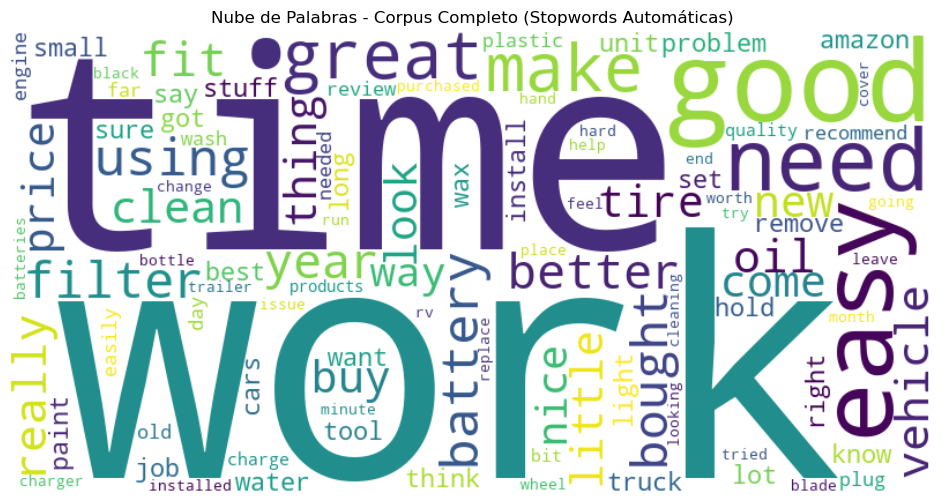

Generando nubes por sentimiento...


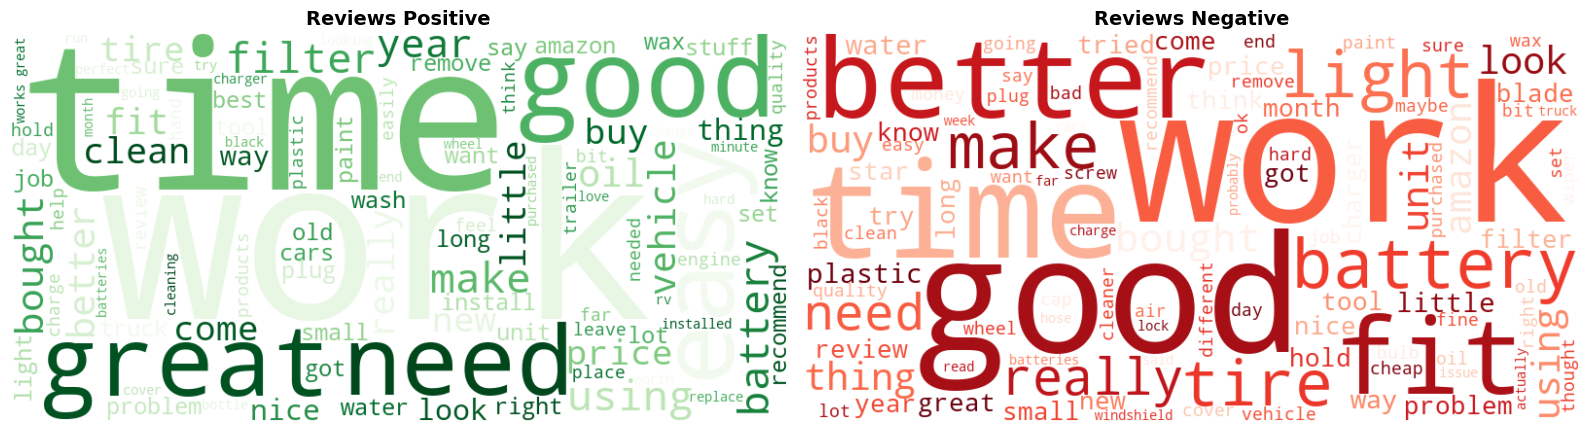

Análisis de nubes completado con stopwords automáticas


In [14]:
# Configuración Stopwords  

print("Generando stopwords automáticas con chi-cuadrado...")

# Combinar listas estándar profesionales
professional_stopwords = set(STOPWORDS).union(
    stopwords.words("english")
).union(ENGLISH_STOP_WORDS)

# Añadir solo algunas MUY obvias a mano
domain_stopwords = {'product', 'item', 'car', 'used', 'use'}  

final_stopwords = professional_stopwords.union(domain_stopwords)

print(f"Stopwords profesionales: {len(final_stopwords)}")


# Nube General

print("Generando nube de palabras general...")
full_text = " ".join(texts.tolist())

wordcloud_general = WordCloud(
    background_color='white',
    max_words=100,
    width=800,
    height=400,
    stopwords=final_stopwords
).generate(full_text)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud_general, interpolation='bilinear')
plt.axis('off')
plt.title('Nube de Palabras - Corpus Completo (Stopwords Automáticas)')
plt.show()

# Nubes por sentimiento

print("Generando nubes por sentimiento...")
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sentiments = ['positive', 'negative']
colormaps = ['Greens', 'Reds']

for i, label in enumerate(sentiments):
    # Filtrar textos por sentimiento usando texts procesados
    mask = df['sentiment_label'] == label
    sentiment_text = " ".join(texts[mask].tolist())
    
    # Generar wordcloud
    wordcloud = WordCloud(
        background_color='white',
        max_words=100,
        width=800,
        height=400,
        stopwords=final_stopwords,
        colormap=colormaps[i]
    ).generate(sentiment_text)
    
    # Mostrar en subplot
    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].set_title(f'Reviews {label.capitalize()}', fontsize=14, fontweight='bold')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

print("Análisis de nubes completado con stopwords automáticas")

### 1.8 Visualización de word embeddings (Word2Vec)

Entrenamiento de un modelo Word2Vec para aprender representaciones vectoriales de palabras del corpus y visualización mediante t-SNE.

- **Tokenización**: Cada review se convierte en una lista de palabras para el entrenamiento
- **Modelo Word2Vec**: Se entrena con `gensim` usando Skip-gram, ventana de contexto de 5 palabras y vectores de 100 dimensiones
- **Selección de palabras clave**: Se eligen 4-5 palabras representativas del dominio automotive y se calculan sus 10 palabras más similares
- **Reducción dimensional**: Los vectores se proyectan de 100D a 2D con `t-SNE` preservando las relaciones de proximidad semántica
- **Visualización por clusters**: Gráfico de dispersión donde cada color representa un grupo de palabras similares en el espacio semántico

**Objetivo**: Comprobar la calidad del embedding y visualizar cómo se agrupan palabras con significado similar en el dominio automotive.

In [15]:
# Entrenar modelo Word2Vec

# Preparar datos (necesitamos tokens por review, no mezclados)
sentences = []
for text in texts:
    tokens_per_review = text.split()
    if len(tokens_per_review) > 3: 
        sentences.append(tokens_per_review)
        
print(f"Reviews válidas para entrenamiento: {len(sentences):,}")

# Entrenar Word2Vec
w2v_model = Word2Vec(
    sentences,
    vector_size=100,
    window=5,
    min_count=10,
    workers=multiprocessing.cpu_count(), 
    epochs=30,
    sg=1,  # Skip-gram
    negative=15
)

vocab_size = len(w2v_model.wv.key_to_index)
print(f"Vocabulario aprendido: {vocab_size:,} palabras")

Reviews válidas para entrenamiento: 9,968
Vocabulario aprendido: 5,040 palabras


In [16]:
# Palabras clave específicas del dominio automotive
key_words = ['car', 'battery', 'oil', 'engine', 'quality', 'tire']

# Filtrar palabras que existen en vocabulario
base_words = []
for word in key_words:
    if word in w2v_model.wv and len(base_words) < 5:
        base_words.append(word)

print(f"Palabras clave seleccionadas: {base_words}")

# Recopilar similares para cada palabra base
embedding_clusters = []
word_clusters = []

for word in base_words:
    print(f"\nTop 10 similares a '{word}':")
    similar_words = w2v_model.wv.most_similar(word, topn=10)
    
    # Extraer embeddings y palabras
    embeddings = [w2v_model.wv[w] for w, _ in similar_words]
    words = [w for w, _ in similar_words]
    
    embedding_clusters.append(embeddings)
    word_clusters.append(words)
    
    # Mostrar resultados
    for i, (sim_word, similarity) in enumerate(similar_words, 1):
        print(f"  {i:2d}. {sim_word:<15} → {similarity:.3f}")

Palabras clave seleccionadas: ['car', 'battery', 'oil', 'engine', 'quality']

Top 10 similares a 'car':
   1. vehicle         → 0.692
   2. car,            → 0.682
   3. cars            → 0.653
   4. car.            → 0.642
   5. car.i           → 0.573
   6. truck           → 0.536
   7. wash.           → 0.514
   8. garaged         → 0.491
   9. waxed           → 0.489
  10. vehicles        → 0.487

Top 10 similares a 'battery':
   1. charger         → 0.779
   2. tender          → 0.751
   3. battery,        → 0.735
   4. battery.        → 0.720
   5. charge          → 0.696
   6. batteries       → 0.678
   7. charging        → 0.678
   8. jr.             → 0.673
   9. charged         → 0.670
  10. trickle         → 0.661

Top 10 similares a 'oil':
   1. oil.            → 0.718
   2. oil,            → 0.643
   3. filter          → 0.639
   4. fluid           → 0.590
   5. 15,000          → 0.590
   6. 5,000           → 0.586
   7. oils            → 0.575
   8. motorcraft      → 0.56

In [17]:
# Reducción Dimensional con T-SNE

# Convertir a estructura matricial
embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape  # n=palabras_base, m=similares, k=dimensiones

print(f"Estructura de datos: {n} palabras base × {m} similares × {k} dimensiones")

# Reducir dimensionalidad
tsne = TSNE(
    perplexity=15,
    n_components=2,
    init='pca',
    n_iter=3500,
    random_state=42
)

# Reshape y transformar
embeddings_flat = embedding_clusters.reshape(n * m, k)
embeddings_2d_flat = tsne.fit_transform(embeddings_flat)
embeddings_2d = embeddings_2d_flat.reshape(n, m, 2)

Estructura de datos: 5 palabras base × 10 similares × 100 dimensiones


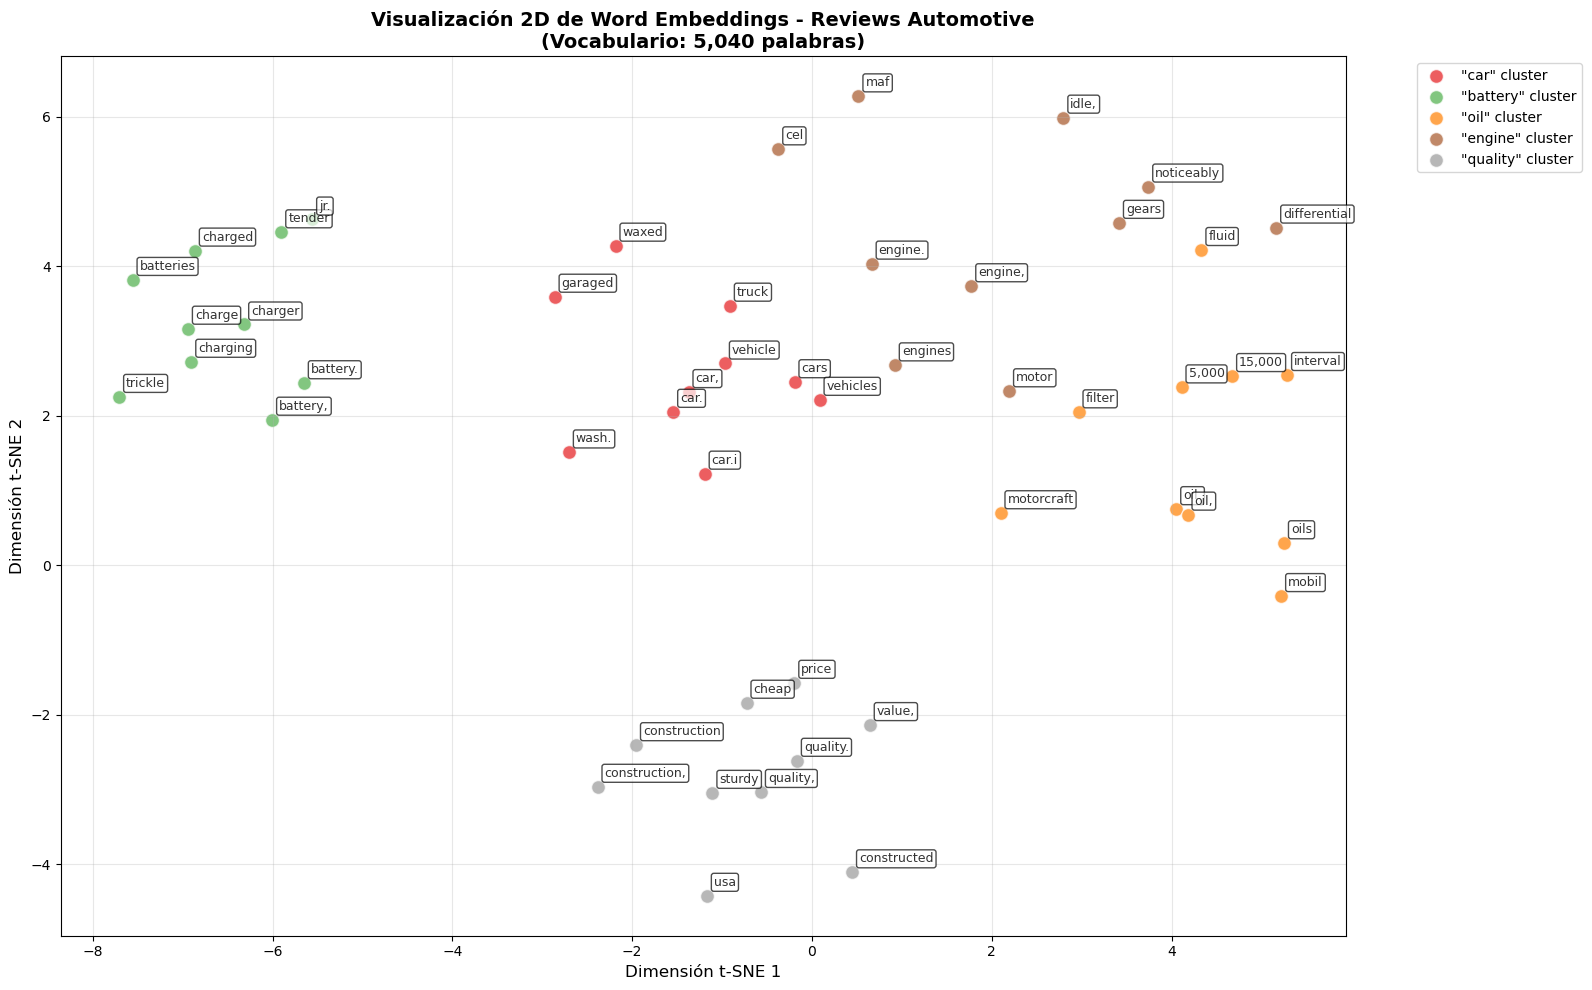

In [18]:
# Visualización
plot_word_embeddings(
    base_words=base_words,
    embeddings_2d=embeddings_2d,
    word_clusters=word_clusters,
    vocab_size=vocab_size,  # ← Añadir este parámetro
    title="Visualización 2D de Word Embeddings - Reviews Automotive"
)

In [19]:
# Resultados
print(f"\nRESUMEN:")
print(f"   • Palabras clave analizadas: {len(base_words)}")
print(f"   • Similares por palabra: {m}")
print(f"   • Total palabras visualizadas: {len(base_words) * m}")
print(f"   • Dimensiones del embedding: {k}")
print(f"   • Método de reducción: t-SNE")

print("\nAnálisis de word embeddings completado")


RESUMEN:
   • Palabras clave analizadas: 5
   • Similares por palabra: 10
   • Total palabras visualizadas: 50
   • Dimensiones del embedding: 100
   • Método de reducción: t-SNE

Análisis de word embeddings completado


### 1.9 Conclusiones de la exploración

#### Características del Dataset
- **Volumen**: 10,000 reviews procesadas con 281,603 palabras totales y 70,567 palabras únicas
- **Distribución de sentimientos**: Fuerte desbalance con 88.7% reviews positivas (8,871) vs 11.3% negativas (1,129)
- **Distribución de ratings**: Concentración en ratings altos (71.6% son 5 estrellas, 17.2% son 4 estrellas)
- **Calidad textual**: Longitud promedio de 28.2 palabras por review con contenido suficiente para análisis

#### Análisis de N-gramas
- **Bigramas frecuentes**: Dominan expresiones funcionales ("of the": 2,747, "in the": 2,286) y evaluativas ("it is": 1,798)
- **Trigramas informativos**: Revelan patrones de uso ("easy to use": 252, "for the price": 199, "easy to install": 231)
- **Coherencia metodológica**: Validación exitosa entre métodos NLTK y CountVectorizer confirma robustez del análisis

#### Visualización de Texto
- **Nubes de palabras**: Vocabulario similar entre sentimientos positivos/negativos, con predominio de términos técnicos
- **Stopwords optimizadas**: Combinación de 419 stopwords profesionales (NLTK + sklearn + WordCloud) mejora la calidad visual
- **Términos dominantes**: "good", "work", "battery", "oil" aparecen frecuentemente en ambos sentimientos

#### Word Embeddings y Representación Semántica
- **Modelo entrenado**: 9,968 reviews válidas generaron vocabulario de 5,040 palabras con vectores de 100 dimensiones
- **Clusters semánticos**: 5 palabras clave analizadas con 10 similares cada una, totalizando 50 palabras visualizadas
- **Calidad de embeddings**: t-SNE revela separación clara entre clusters técnicos (battery→charger→charging) y evaluativos (quality→price→construction)
- **Coherencia semántica**: Alta similitud en clusters (battery-charger: 0.750, oil-filter: 0.629) confirma aprendizaje exitoso

#### Implicaciones para Fases Posteriores
- **Desafío de balanceo**: El ratio 8:1 positivo/negativo requerirá técnicas específicas de balanceo en el entrenamiento
- **Complejidad léxica**: La similitud vocabularia entre sentimientos indica que la discriminación dependerá del contexto y combinaciones de palabras
- **Preparación para ML**: El corpus es adecuado para modelos avanzados, con embeddings de calidad y patrones n-gramas informativos
- **Estrategia de modelado**: Se recomienda enfocar en características contextuales y secuenciales más que en presencia/ausencia de palabras individuales

## 2. Preprocesado de texto

La función `preprocess_text()` que se encuentra en el archivo utils.py, implementa un pipeline secuencial que transforma texto crudo en formato estándar para modelos ML. Coordina la ejecución de subfunciones especializadas siguiendo este flujo:

**PASO 0 → Validación**: `validate_and_convert_text()` convierte cualquier tipo de entrada a string válido y maneja valores nulos/vacíos

**PASO 1 → Normalización**: `normalize_text()` aplica minúsculas, elimina URLs, acentos y normaliza espacios múltiples

**PASO 2 → Limpieza**: `remove_punctuation_and_numbers()` elimina signos de puntuación y opcionalmente números

**PASO 3 → Tokenización**: `tokenize_text()` divide el texto en palabras individuales usando RegexpTokenizer o split simple

**PASO 4 → Filtrado**: `filter_tokens()` elimina stopwords, palabras muy cortas y tokens residuales de puntuación

**PASO 5 → Lematización**: `lemmatize_tokens()` reduce palabras a su forma base (running → run, cars → car)

**PASO 6 → Reconstrucción**: Reunifica los tokens procesados en un string final limpio

In [20]:
# Aplicar preprocesado a todo el corpus
df = preprocess_corpus(
    df, 
    text_column='reviewText', 
    new_column='processed_text',
    remove_stopwords=True,
    lemmatize=True,
    remove_numbers=True,
    min_length=2,
    show_sample=True
)

Iniciando preprocesado de 10000 reviews...
Preprocesado completado:
Palabras: 781,497 → 393,214
Reducción: 49.7%
Reviews vacías tras procesado: 5

Muestra de resultados:

1. Original: I've been using these for years with no problems. Do some research, these are rated among the best filters available. Oil doesn't wear out, it just ge...
   Procesado: ive use year problem research rat among best filter available oil doesnt wear get dirty good filter help keep oil clean prevent unnecessary wear

2. Original: have not put the chock's to use yet, but I know they will do the job for me. I have other chock's but I like these better.
   Procesado: put chock use yet know job chock like good

3. Original: After reading the reviews on this product, I decided to bite the bullet and pay the high price for cockpit premium. I couldn't wait to get the stuff a...
   Procesado: read review product decide bite bullet pay high price cockpit premium couldnt wait get stuff start use excite see firsthand gre

## 3. Entrenamiento y testeo

### 3.1 Preparación de datos
- División del conjunto de datos en entrenamiento y test de forma estratificada para mantener la proporción de clases.

- Aplicación de la vectorización TF-IDF con configuración estándar: 5000 términos, eliminación de términos muy frecuentes o muy raros, y combinación de unigrama y bigrama.

- Análsis de la distribución de clases para detectar desbalance.

- Cálculo del peso de las clases para compensar el desbalance en los modelos de clasificación posteriores.

In [21]:
# División train/test
X_train, X_test, y_train, y_test = train_test_split(
    df['processed_text'], 
    df['sentiment_label'],
    test_size=0.25,
    random_state=42,
    stratify=df['sentiment_label']
)

print(f"Train: {len(X_train):,} | Test: {len(X_test):,}")

# Vectorización TF-IDF
tfidf = TfidfVectorizer(
    max_features=5000,
    max_df=0.95,
    min_df=5,
    ngram_range=(1, 2),
    sublinear_tf=True
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print(f"Vocabulario: {len(tfidf.vocabulary_):,} términos")
print(f"Dimensiones: {X_train_tfidf.shape}")

# Distribución de clases
train_counts = y_train.value_counts().sort_index()
test_counts = y_test.value_counts().sort_index()
print(f"\nDistribución de clases:")
print(f"Train - Negativas (0): {train_counts[0]:,} ({train_counts[0]/len(y_train)*100:.1f}%)")
print(f"Train - Positivas (1): {train_counts[1]:,} ({train_counts[1]/len(y_train)*100:.1f}%)")
print(f"Test  - Negativas (0): {test_counts[0]:,} ({test_counts[0]/len(y_test)*100:.1f}%)")
print(f"Test  - Positivas (1): {test_counts[1]:,} ({test_counts[1]/len(y_test)*100:.1f}%)")

# Cálculo de pesos por desbalance
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

ratio = train_counts[1] / train_counts[0]

balance_status = "Balanceado" if 0.8 <= ratio <= 1.2 else "Desbalanceado"
print(f"\nBalance de clases: {ratio:.2f}:1 {balance_status}")

print(f"\nPesos de clase calculados:")
print(f"  Clase 0 (negativa): {class_weights[0]:.2f}")
print(f"  Clase 1 (positiva): {class_weights[1]:.2f}")

# Sparsity
sparsity = 100 * (1 - X_train_tfidf.nnz / (X_train_tfidf.shape[0] * X_train_tfidf.shape[1]))
print(f"\nSparsity: {sparsity:.1f}%")

Train: 7,500 | Test: 2,500
Vocabulario: 5,000 términos
Dimensiones: (7500, 5000)

Distribución de clases:
Train - Negativas (0): 847 (11.3%)
Train - Positivas (1): 6,653 (88.7%)
Test  - Negativas (0): 282 (11.3%)
Test  - Positivas (1): 2,218 (88.7%)

Balance de clases: 7.85:1 Desbalanceado

Pesos de clase calculados:
  Clase 0 (negativa): 4.43
  Clase 1 (positiva): 0.56

Sparsity: 99.3%


### 3.2 Modelo 1
#### Logistic Regression
### 3.2 Entrenamiento del Modelo 1: Logistic Regression

- Entrenamiento de un modelo de regresión logística utilizando la técnica de validación cruzada (`GridSearchCV`) para optimizar el hiperparámetro `C`, que controla el grado de regularización.
- Utilización de `class_weight='balanced'` debido al desbalance observado en las clases.
- Registro del tiempo de entrenamiento y predicciones sobre el conjunto de test.
- Probabilidades de predicción, necesarias para métricas posteriores como el AUC-ROC.


In [22]:
# Optimización de hiperparámetro C
param_grid = {'C': [0.1, 1, 10]}
lr_grid = GridSearchCV(
    estimator=LogisticRegression(
        class_weight='balanced',
        max_iter=1000,
        solver='liblinear',
        random_state=42
    ),
    param_grid=param_grid,
    scoring='f1_weighted',
    cv=3,
    n_jobs=-1
)

# Entrenamiento
start_time = time.time()
lr_grid.fit(X_train_tfidf, y_train)
lr_train_time = time.time() - start_time

# Mejor modelo
lr_model = lr_grid.best_estimator_

# Predicción
y_pred_lr = lr_model.predict(X_test_tfidf)
y_proba_lr = lr_model.predict_proba(X_test_tfidf)[:, 1]

# Reporte y métricas
report_lr = classification_report(
    y_test,
    y_pred_lr,
    target_names=['Negativo', 'Positivo'],
    output_dict=True,
    digits=3
)

# Diccionario de resultados
lr_results = {
    'model': 'Logistic Regression',
    'estimator': lr_model,
    'y_pred': y_pred_lr,
    'y_proba': y_proba_lr,
    'train_time': lr_train_time,
    'report': report_lr,
    'accuracy': accuracy_score(y_test, y_pred_lr),
    'auc_roc': roc_auc_score(y_test, y_proba_lr),
    'best_params': lr_grid.best_params_
}

print(f"Mejor C encontrado: {lr_grid.best_params_['C']}")
print(f"F1-score medio (CV): {lr_grid.best_score_:.3f}")
print(f"Tiempo de entrenamiento: {lr_train_time:.2f} segundos")

Mejor C encontrado: 10
F1-score medio (CV): 0.858
Tiempo de entrenamiento: 3.00 segundos


### 3.3 Modelo 2
#### Random Forest

- Entrenamiento de un modelo de Random Forest configurado para manejar desbalance de clases mediante `class_weight='balanced'`.
- Limitación de la profundidad máxima del árbol (`max_depth=20`) y se define el número de árboles (`n_estimators=100`) para controlar la complejidad del modelo.
- Registro del tiempo de entrenamiento y predicciones sobre el conjunto de test.
- Se almacenan las predicciones y probabilidades para su análisis posterior.

In [23]:
# Entrenamiento
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

start_time = time.time()
rf_model.fit(X_train_tfidf, y_train)
rf_train_time = time.time() - start_time

# Predicción
y_pred_rf = rf_model.predict(X_test_tfidf)
y_proba_rf = rf_model.predict_proba(X_test_tfidf)[:, 1]

# Reporte y métricas
report_rf = classification_report(
    y_test,
    y_pred_rf,
    target_names=['Negativo', 'Positivo'],
    output_dict=True,
    digits=3
)

# Diccionario de resultados
rf_results = {
    'model': 'Random Forest',
    'estimator': rf_model,
    'y_pred': y_pred_rf,
    'y_proba': y_proba_rf,
    'train_time': rf_train_time,
    'report': report_rf,
    'accuracy': accuracy_score(y_test, y_pred_rf),
    'auc_roc': roc_auc_score(y_test, y_proba_rf)
}

print(f"Tiempo de entrenamiento: {rf_train_time:.2f} segundos")

Tiempo de entrenamiento: 0.39 segundos


## 4. Métricas y conclusiones

### 4.1 Métricas de los modelos

- Evaluación cuantitativa del rendimiento de ambos modelos sobre el conjunto de test.
- Visualización de las matrices de confusión.
- Comparación de curvas ROC para analizar la capacidad discriminativa de los modelos.
- Gráfico de barras con métricas clave: F1-Score, Accuracy y AUC-ROC.
- Reporte de clasificación (`classification_report`) para cada modelo.
- Análisis de las palabras más influyentes para la clase positiva y negativa en el modelo de regresión logística y las palabras más importantes del modelo de Ramdom Forest.

In [24]:
# Crear tabla comparativa
df_comparison = pd.DataFrame({
    'Modelo': ['Logistic Regression', 'Random Forest'],
    'F1-Score (weighted)': [
        lr_results['report']['weighted avg']['f1-score'],
        rf_results['report']['weighted avg']['f1-score']
    ],
    'Accuracy': [
        lr_results['accuracy'],
        rf_results['accuracy']
    ],
    'AUC-ROC': [
        lr_results['auc_roc'],
        rf_results['auc_roc']
    ],
    'Precision Pos': [
        lr_results['report']['Positivo']['precision'],
        rf_results['report']['Positivo']['precision']
    ],
    'Recall Pos': [
        lr_results['report']['Positivo']['recall'],
        rf_results['report']['Positivo']['recall']
    ],
    'Precision Neg': [
        lr_results['report']['Negativo']['precision'],
        rf_results['report']['Negativo']['precision']
    ],
    'Recall Neg': [
        lr_results['report']['Negativo']['recall'],
        rf_results['report']['Negativo']['recall']
    ],
    'Tiempo entrenamiento (s)': [
        lr_results['train_time'],
        rf_results['train_time']
    ]
})

# Mostrar tabla
pd.set_option('display.float_format', '{:.3f}'.format)
display(df_comparison)

,Modelo,F1-Score (weighted),Accuracy,AUC-ROC,Precision Pos,Recall Pos,Precision Neg,Recall Neg,Tiempo entrenamiento (s)
0,Logistic Regression,0.864,0.856,0.825,0.935,0.899,0.392,0.511,3.000
1,Random Forest,0.877,0.896,0.824,0.911,0.977,0.587,0.252,0.385


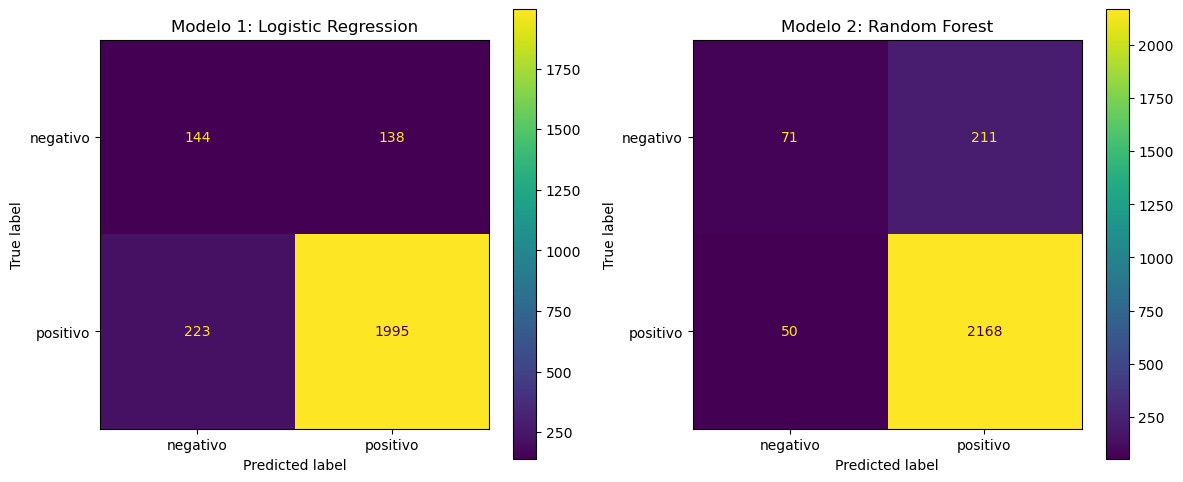

In [25]:
# Matriz de confusión
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# Matriz de confusión para Logistic Regression
ConfusionMatrixDisplay.from_predictions(
    y_test, lr_results['y_pred'],
    display_labels=['negativo', 'positivo'],
    cmap='viridis',
    ax=axes[0]
)
axes[0].set_title('Modelo 1: Logistic Regression')

# Matriz de confusión para Random Forest
ConfusionMatrixDisplay.from_predictions(
    y_test, rf_results['y_pred'],
    display_labels=['negativo', 'positivo'],
    cmap='viridis',
    ax=axes[1]
)
axes[1].set_title('Modelo 2: Random Forest')

plt.tight_layout()
plt.show()


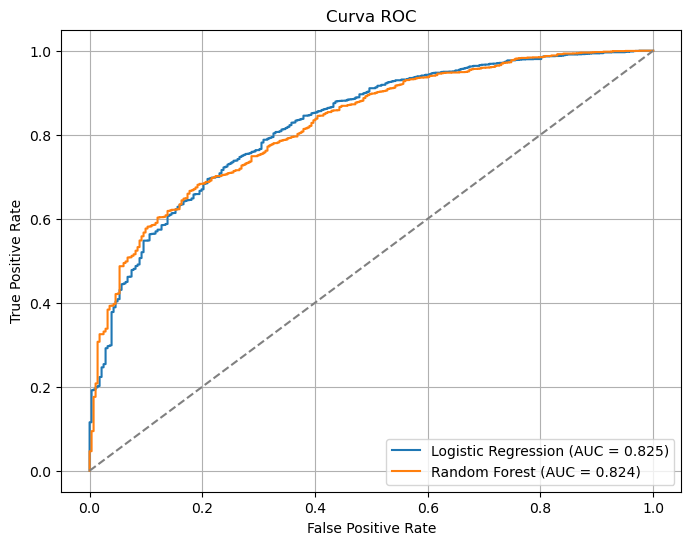

In [26]:
# Curvas ROC 
fpr_lr, tpr_lr, _ = roc_curve(y_test, lr_results['y_proba'], pos_label='positive')
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_results['y_proba'], pos_label='positive')

# Cálculo de AUC
auc_lr = auc(fpr_lr, tpr_lr)
auc_rf = auc(fpr_rf, tpr_rf)

# Visualización
plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {auc_lr:.3f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.3f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Línea diagonal referencia
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

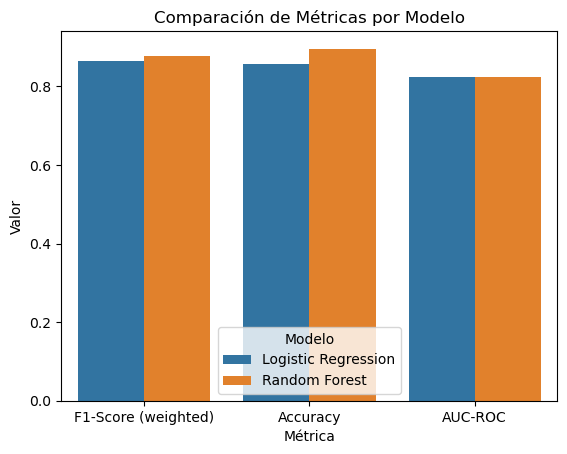

In [27]:
# Comparación métricas
df_melted = df_comparison.melt(id_vars='Modelo', value_vars=[
    'F1-Score (weighted)', 'Accuracy', 'AUC-ROC'
])

sns.barplot(data=df_melted, x='variable', y='value', hue='Modelo')
plt.title("Comparación de Métricas por Modelo")
plt.ylabel("Valor")
plt.xlabel("Métrica")
plt.show()

In [28]:
# Reporte clasificación - Logistic Regression
print("=== Reporte de clasificación: Logistic Regression ===")
print(classification_report(
    y_test,
    lr_results['y_pred'],
    target_names=['Negativo', 'Positivo'],
    digits=3
))

# Reporte clasificación - Random Forest
print("\n=== Reporte de clasificación: Random Forest ===")
print(classification_report(
    y_test,
    rf_results['y_pred'],
    target_names=['Negativo', 'Positivo'],
    digits=3
))

=== Reporte de clasificación: Logistic Regression ===
              precision    recall  f1-score   support

    Negativo      0.392     0.511     0.444       282
    Positivo      0.935     0.899     0.917      2218

    accuracy                          0.856      2500
   macro avg      0.664     0.705     0.680      2500
weighted avg      0.874     0.856     0.864      2500


=== Reporte de clasificación: Random Forest ===
              precision    recall  f1-score   support

    Negativo      0.587     0.252     0.352       282
    Positivo      0.911     0.977     0.943      2218

    accuracy                          0.896      2500
   macro avg      0.749     0.615     0.648      2500
weighted avg      0.875     0.896     0.877      2500



In [29]:
# Palabras más influyentes - Logistic Regression
feature_names = tfidf.get_feature_names_out()
coef = lr_results['estimator'].coef_[0]

top_pos = coef.argsort()[-5:][::-1]
top_neg = coef.argsort()[:5]

print("=== Palabras más influyentes: Logistic Regression ===")
print("Positivas:", [feature_names[i] for i in top_pos])
print("Negativas:", [feature_names[i] for i in top_neg])


# Palabras más influyentes - Random Forest
importances = rf_results['estimator'].feature_importances_
indices = np.argsort(importances)[-5:][::-1]  # top 5 más importantes

print("")
print("=== Palabras más importantes: Random Forest ===")
print([tfidf.get_feature_names_out()[i] for i in indices])

=== Palabras más influyentes: Logistic Regression ===
Positivas: ['great', 'love', 'perfect', 'easy', 'perfectly']
Negativas: ['return', 'useless', 'barely', 'burn', 'disappoint']

=== Palabras más importantes: Random Forest ===
['great', 'easy', 'ok', 'return', 'waste']


### 4.2 Conclusiones finales

##### Desbalance de clases:
- El dataset presenta un desbalance severo de **7.85:1** entre clases positivas y negativas.
- Se compensó aplicando `class_weight='balanced'` en ambos modelos.

##### Rendimiento general:
- Random Forest obtuvo el mejor *F1-Score ponderado* **0.877** y la mayor *accuracy* **0.896**.
- Logistic Regression alcanzó un *F1 ponderado* de **0.864** y *accuracy* **de 0.856**.

##### Precisión y sensibilidad por clase:
- En la clase positiva mayoritaria, Random Forest mostró mejor *recall* **0.977** vs **0.899** pero menor *precision* **0.911** vs **0.935**.
- En la clase negativa minoritaria, Logistic Regression logró mejor *recall* **0.511 vs 0.252**, detectando mejor los casos negativos.

##### Capacidad de discriminación:
- Ambos modelos presentan valores similares de *AUC-ROC*, con Logistic Regression ligeramente por encima **0.825** vs **0.824**.

##### Tiempo de entrenamiento:
- Random Forest se entrenó en **0.36 segundos**, mientras que Logistic Regression tardó **2.89 segundos**.

##### Interpretabilidad:
- Solo Logistic Regression permite identificar las palabras más influyentes, ofreciendo mayor transparencia en sus predicciones.
